# Adaptive Cruise Control (ACC)

Safety is critical in autonomous driving. In this task, you will design an optimization based safety-critical controller that enables the vehicle to keep a safe distance to the leading vehicle while trying to reach the desired cruise velocity. 

The key of this problem is the tradeoff between the **safety** and **tracking** of desired velocity. 

## 1. System model

We consider the point mass vehicle model:

$$m \frac{dv}{dt} = F_w,$$

where $m$ is the mass, $v$ is the velocity of the vehicle, and $F_w$ is the traction force. For simplification, we omit other resistances, such as aerodynamic drag. 

In the context of adaptive cruise control, let the velocity of leading vehicle be $v_0$. Thus, the distance between the two vehicle $D$ is governed by:

$$\frac{dD}{dt} = v_0 - v.$$ 

Then we have the dynamics of the system as:

$$
\frac{d}{dt}\begin{bmatrix} D\\ v \end{bmatrix} = \begin{bmatrix} v_0 - v \\ 0 \end{bmatrix} + \begin{bmatrix} 0\\ \frac{1}{m} \end{bmatrix} F_w.
$$

We assume $v_0$ is piecewise constant in this task. 

Now we introduce the constraints need to be considered in the controller design.

![system overview](CBF_car2.png)

## 2. Constraints

### 2.1 Input constraints

The traction and braking force can not exceed the allowable wheel forces:

$$-c_d g \le \frac{F_w}{m} \le c_a g,$$

where $g$ is the gravity, $c_d$ and $c_a$ are the coefficients that indicates the allowable braking and traction force. 


### 2.2 Soft constraints

We wish the vehicle to achieve the desired cruise velocity $v_d$:

$$(v - v_d)^2 \rightarrow 0.$$ 


### 2.3 Hard constraints


#### 2.3.1 Half-speedometer safety constraints

For ACC, we want to keep a safe distance from the leading vehicle.

We enforce the **half-speedometer** rule [6], such that the minimum distances between two vehicles to be half of the speedometer:

$$D \ge \frac{v}{2},$$ 

with $D$ in $m$ and $v$ in $km / hr$. For example, if the leading vehicle is traveling at $80km/hr$, the minimum distance should be $40m$.

When we convert the unit of $v$ to $m / s$, we have:

$$D \ge 1.8v.$$

#### 2.3.2 $T$-lookahead distance

To ensure safety while approaching the leading vehicle, we want the ego vehicle to always be able to maintain safe distance using the **maximal** braking force. Under maximum braking force, we have the dynamics of the vehicle starting at time $t$ as:

$$
v(t+\tau)=v(t)-\tau c_d g,
$$

and thus solving for $T$ such that $v(t+T)=v_0$ (following at the velocity of the lead vehicle) yields

$$
T=\frac{v_0-v(t)}{-c_d g} .
$$

Then integrating the dynamics of $D$ yields:

$$
\begin{aligned}
D(t+T) & =D(t)+\int_0^T\left[v_0-v(t+\tau)\right] d \tau \\
& =D(t)+\int_0^T\left[v_0-v(t)+\tau c_d g\right] d \tau \\
& =D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g}
\end{aligned}
$$

Hence, if the current headway is $D(t)$, the headway looking $T$ seconds ahead, which is based on decelerating at the maximum rate to a following speed of $v_0$, is bounded by

$$
D(t+T)=D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g}.
$$

Finally, we have the safety constraints that ensure the vehicle always maintain the half of the speedometer distance by applying the maximum braking forces:

$$
D(t+T) = D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g} \ge 1.8v(t).
$$

## 3. Controller design

Our goal is to design a controller that satsify the safety constraints

$$D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g} \ge 1.8v(t), \forall t > 0,$$

and let the velocity $v$ go as close to $v_d$ as possible within the control limit.

However, we note that the LQR designed in class is equivalent to enforcing an **equality constraint** to ensure convergence to the desired states, which leaves no space for safety. Here we replace the equality constraint with an **inequality constraint**.

### 3.1 Linear state feedback

To track the desired velocity, the linear feedback, such as LQR, takes the form:

$F_w = -K(v - v_d)$, where $K \in \mathbb{R}_{+}$ is the gain that decide how fast you can regularize $(v - v_d)$ to 0. 

Now we define the tracking performance as the square of the tracking error, i.e. 

$$h = \frac{(v - v_d)^2}{2}.$$

Then we take derivative of $h$ with respect to time, 

$$
\begin{equation}
\begin{aligned}

\dot{h} &= \frac{\partial h}{\partial v} \frac{dv}{dt} \\
        &= 0 + (v - v_d) \frac{F_w}{m} \\
        &= - \frac{K(v - v_d)^2}{m} \\
        &= -\frac{2K}{m}h

\end{aligned}
\end{equation}
$$

Thus, solving the ODE, we have:

$$h(t) = \exp{(-\frac{2K}{m} t)} h(0),$$ 

with $h(0) = \frac{1}{2}(v(0) - v_d)^2$, which gurantees $(v - v_d)^2 \rightarrow 0$, as $t \rightarrow \infty$. 

### 3.2 Tracking constraint as inequality

To allow the tradeoff for safety constraints, we replace the state feedback by inequality constraints on the tracking error:

Instead of Find $F_w$ to ensure $$\dot{h} = -\lambda h, $$

we only try to find $F_w$ to make $$\dot{h} \le -\lambda h, \text{ for some } \lambda > 0.$$

<!-- we can bound the value of $h$ by manipulating its change rate with respect to time. -->

<!-- By the comparison lemma[4], for a scalar function $h_1(t)$, if there exist another function $h_2(t)$, such that the time derivative $\dot{h}_1(t) \le \dot{h}_2(t)$ and initial value $h_1(0) \le h_2(0)$, we have $0 < h_1(t) \le h_2(t), \forall t$. -->

By the comparison lemma[4], if we can find such $F_w$ for $\forall t\ge 0$, there is an upper bound on the convergence rate of the tracking error:

$${h}(t) \le \exp{(-\lambda t)} h(0),$$

given the initial condition that $h(0)\ge 0 $. 

In this case, the upper bound of the tracking error is bounded by ${h}(t) = \exp{(-\lambda t)} h(0)$, which corresponds to a linear state feedback. 

### 3.3 Safety constraints

Similar to the tracking performance, we define the barrier function to indicate the safety 

$$B:= D-\frac{1}{2} \frac{\left[v_0-v\right]^2}{c_d g} - 1.8v.$$

Where $B > 0$ indicate strict satisfaction of the safety constraints. 

If we can find $F_w$ to make $\dot{B} \ge -\alpha B$, with $\alpha > 0$, we have the lower bounds on barrier function if $\exist F_w, \forall t$:

$$
B(t) \ge \exp{(-\alpha t) B(0)} \ge 0, B(0) \ge 0.
$$

### 3.4 QP-based minimum norm controller

If we substitute the dynamics of the vehicle to the above two inequality constraints on $h$ and $B$, we have:

$$
\dot{h} =  \frac{(v - v_d)}{m}F_w \le -\lambda h
$$

$$
\begin{equation}
\begin{aligned}
    \dot{B} =& \frac{d D}{d t} - \frac{d \frac{\left[v_0-v\right]^2}{2c_d g} + 1.8v}{d v}\frac{d v}{d t} \\
            =& (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B
\end{aligned}
\end{equation}
$$

Thus, a straight forward idea to bridge the **safety** and **tracking** performance is to design a controller that generate the smllest control input while satisfying the two inequality constraints:

$$
\begin{equation}
    \begin{aligned}
    \min_{F_w} & \quad F_w^2 \\ 
    \text{s.t. } & \frac{(v - v_d)}{m}F_w \le -\lambda h, \\
                 & (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B, \\
                 & -c_d g \le \frac{F_w}{m} \le c_a g.
    \end{aligned}
\end{equation}
$$

By solving this QP, we are able to find the minimal-norm control input within the control limits, while trying to converge to the desired velocity, and keep the safe distance.

### 3.5 Tackling infeasibility

However, the two inequality may result in empty feasible set for the QP. For example, if the velocity of the leading vehicle is slower than the desired velocity, there is no control input that can enable the velocity converge to the desired one without sacrificing safety.

To solve the problem, we introduce a slack variable $\delta$ that allowing violation of the constraints for velocity tracking. Since the safety is the priority, it should be always satisfied:

$$
\begin{equation}
    \begin{aligned}
    \min_{F_w, \delta} & \quad F_w^2 +  {w \delta^2} \\ 
    \text{s.t. } & \frac{(v - v_d)}{m}F_w \le -\lambda h + \delta, \\
                 & (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B, \\
                 & -c_d g \le \frac{F_w}{m} \le c_a g, \\
                 & \delta \ge 0.
    \end{aligned}
\end{equation}
$$

where $w$ is a large weight that penalize the slack variable.

## 4. Submission

Please fill **ACC_Controller()** to compute the required matrix for the implementation of the slacked QP-based minimal norm controller, $P, q, A$ and $b$. 

You will need to tune the parameters $\lambda$ for tracking, $\alpha$ for safety constraints and $w$ for the weight of slack variable.

$$
\begin{equation}
    \begin{aligned}
    \min_{x} & \quad \frac{1}{2}x^{T}Px + q^{T}x \\ 
    \text{s.t. } & Ax\le b
    \end{aligned}
\end{equation}
$$

Note: $x:= [F_w, \delta]$ and $A \in \mathbb{R}^{5\times 2}$. We will use the first variable produced by the QP solver as the control input.

### 4.1 Requirement

1. The safety constraints $B\ge 0$ is satisfied all time before the vehicle changes velocity.

2. The vehicle reaches the desired speed when it is allowed, e.g., before the leading vehicle changes its velocity or the leading vehicle's velocity is faster than the desired speed. 

3. No collision detected all the time. 

4. Input constraints are not violated. 

5. The QP is always feasible.


### 4.2 Remark
1. The leading car will change its velocity at the swtich time shown in the **param**.

2. $v_{01}$ and $v_{02}$ are the leading car velocity before and after the switch time. $y_0:= [D(0), v(0)]$ is the initial state and $v_d$ is the desired velocity.

3. We will test your controller with varying $v_d$, $v_{01}$, $v_{02}$ and $y_0$. You can use the range specified in the comments as a reference to test your controller.

4. Try these situations: static leading vehicle, emergency stop, large desired velocity.

5. We will not penalize test cases that is impossible to gurantee safety. If you are interested, refer to [5] about how to know when it is possible or not to maintain the safety. 

In [10]:
%load_ext autoreload
%autoreload 2
from acc_controller import ACC_Controller
from acc_utils import *
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


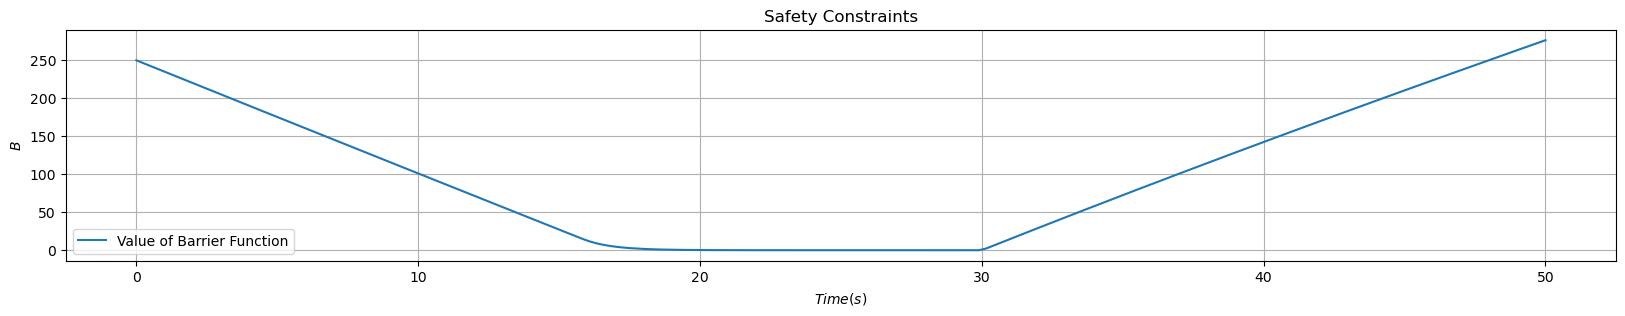

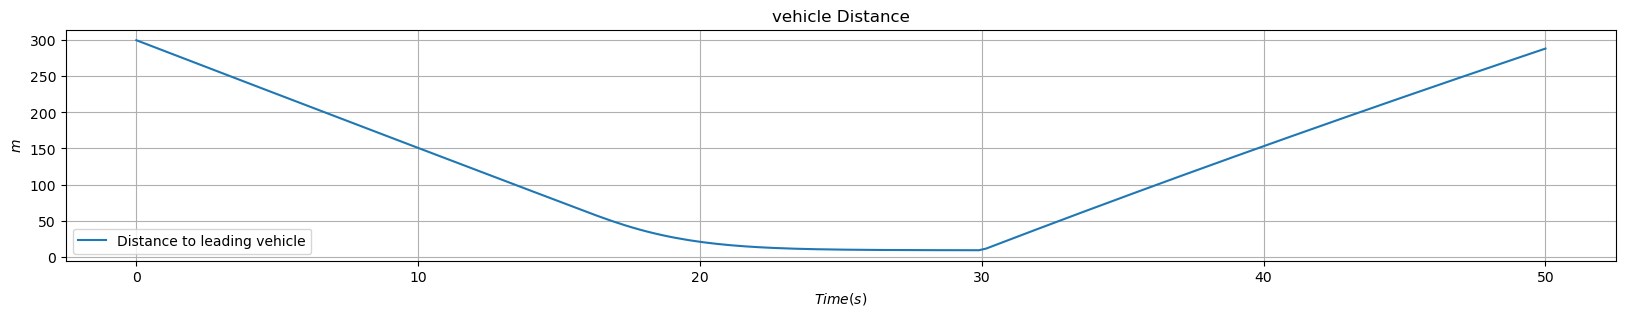

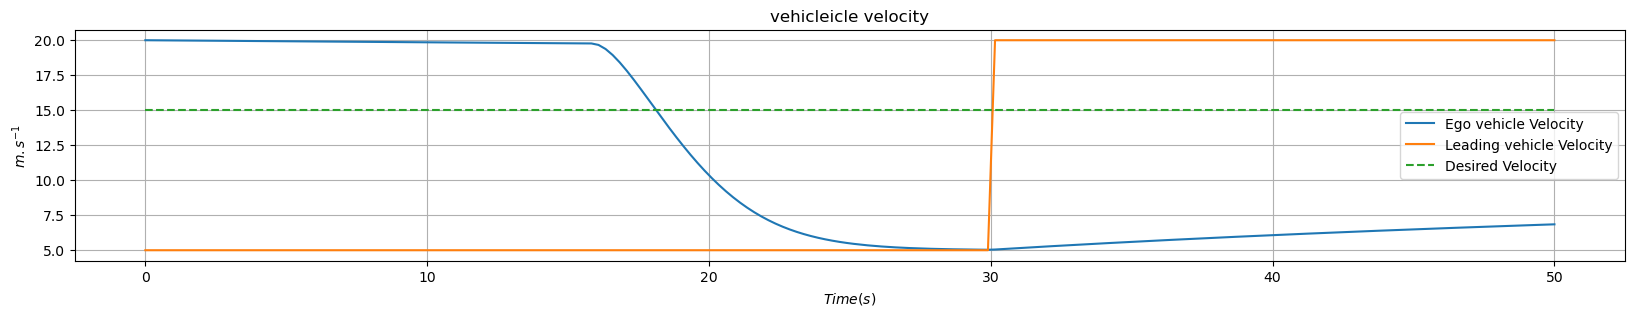

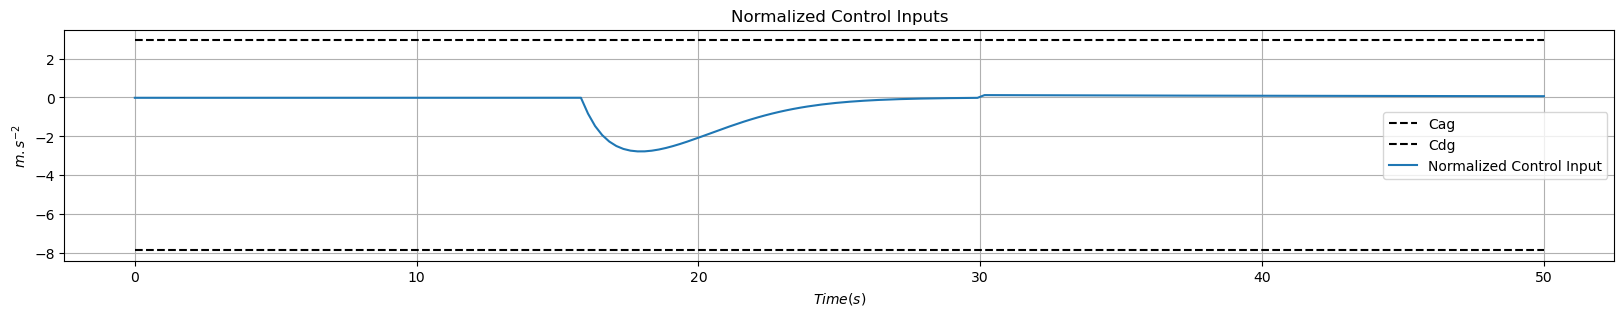

In [11]:
param = {
    "vd": 15,           # desired velocity, 0-30
    "m": 2000,
    "Cag": 0.3 * 9.81,
    "Cdg": 0.8 * 9.81,
    "v01": 5,           # velocity of leading vehicle before switch_time, 0-10
    "v02": 20,           # velocity of leading vehicle after switch_time, 10-60
    "switch_time": 30,
    "terminal_time": 50
}
y0 = np.array([300, 20]) # [D(0), v(0)], D(0) 0-500, v(0) 0-50
t, B, y, u = sim_vehicle(ACC_Controller, param, y0)

plt.figure(figsize=(20, 3))
plt.plot(t, B, label="Value of Barrier Function")
plt.xlabel('$Time (s)$')
plt.ylabel('$B$')
plt.title('Safety Constraints')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(t, y[:, 0], label="Distance to leading vehicle")
plt.xlabel('$Time (s)$')
plt.ylabel('$m$')
plt.title('vehicle Distance')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(t, y[:, 1], label="Ego vehicle Velocity")
v_lead = t * 0
v_lead[t <= param["switch_time"]] = param["v01"]
v_lead[t >= param["switch_time"]] = param["v02"]
plt.plot(t, v_lead, label="Leading vehicle Velocity")
plt.plot(t, t * 0 + param["vd"], "--", label="Desired Velocity")

plt.xlabel('$Time (s)$')
plt.ylabel('$m.s^{-1}$')
plt.title('vehicleicle velocity')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(t, 0 * t - param["Cdg"], "k--", label="Cag")
plt.plot(t, 0 * t + param["Cag"], "k--", label="Cdg")
plt.plot(t, u / param["m"], label="Normalized Control Input")
plt.xlabel('$Time (s)$')
plt.ylabel('$m.s^{-2}$')
plt.title('Normalized Control Inputs')
plt.legend()
plt.grid()
plt.show()

## Background

### Comparison lemma

The following comparison lemma enable us to convert the linear state feedback to a inequality constraints. 

Consider the the scalar differential equation
$$
\dot{u}=f(t, u), \quad u\left(t_0\right)=u_0
$$
where $f(t, u)$ is continuous in $t$ and locally Lipschitz in $u$, for all $t \geq 0$ and all $u \in J \subset R$. Let $\left[t_0, T\right)$ ( $T$ could be infinity) be the maximal interval of existence of the solution $u(t)$, and suppose $u(t) \in J$ for all $t \in\left[t_0, T\right)$. Let $v(t)$ be a continuous function whose upper right hand derivative $D^{+} v(t)$ satisfies the differential inequality
$$
D^{+} v(t) \leq f(t, v(t)), \quad v\left(t_0\right) \leq u_0
$$
with $v(t) \in J$ for all $t \in\left[t_0, T\right)$. Then, $v(t) \leq u(t)$ for all $t \in\left[t_0, T\right)$.

**The comparison lemma suggests that you can bound the value of $v(t)$ by bounding its derivative compared to a reference function u(t).**

### CLF-CBF-QP Algorithm

The square of the tracking error $h$ is the **control Lyapunov function (CLF)** that specify the **stability**. The function $B$ is the **control barrier function (CBF)** that specify the **safety** in the sense of **forward invariance**. The **CLF-CBF-QP** algorithm bridges the safety and stability via a single QP as we implemented in this task. 

For more details about the **CLF-CBF-QP** algorithm and the notion of **safety**, please redfer to the following papers [1-3].  



## References

[1] Ames, A.D., Grizzle, J.W. and Tabuada, P., 2014, December. Control barrier function based quadratic programs with application to adaptive cruise control. In 53rd IEEE Conference on Decision and Control (pp. 6271-6278). IEEE.

[2] Ames, A.D., Xu, X., Grizzle, J.W. and Tabuada, P., 2016. Control barrier function based quadratic programs for safety critical systems. IEEE Transactions on Automatic Control, 62(8), pp.3861-3876.

[3] Nguyen, Q. and Sreenath, K., 2016, July. Exponential control barrier functions for enforcing high relative-degree safety-critical constraints. In 2016 American Control Conference (ACC) (pp. 322-328). IEEE.

[4] https://en.wikipedia.org/wiki/Gr%C3%B6nwall%27s_inequality

[5] Bansal, S., Chen, M., Herbert, S. and Tomlin, C.J., 2017, December. Hamilton-jacobi reachability: A brief overview and recent advances. In 2017 IEEE 56th Annual Conference on Decision and Control (CDC) (pp. 2242-2253). IEEE.

[6] Vogel, K., 2003. A comparison of headway and time to collision as safety indicators. Accident analysis & prevention, 35(3), pp.427-433.